In [1]:
%load_ext autoreload
%pylab inline

sys.path.insert(0, '..')

import pandas as pd
import xarray as xr
import seaborn
seaborn.set_palette('tab20')

from warnings import filterwarnings
filterwarnings('ignore', category=RuntimeWarning)

from scripts.data import main as data
from scripts import plotting as plot
from scripts import analysis

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Import data using YAML file

Note that this should work on any machine as long as you have the requirements installed. Files will be downloaded to the 

In [33]:
cat = data.read_catalog('../scripts/data/reccap2_data.yml')

In [178]:
# read SOCAT data from the website
# socat = data.socat2020(cat['socat_pco2'], verbose=False)
# liar = data.soccom_float_liar(cat['soccom_liar'], verbose=False)

# reads mask data from the RECCAP website
mask = data.southern_ocean_mask()
subs = mask.subregions

# read reccap data from the FTP site
# the output of reccap_surface_CO2 is a special object that I wrote some code for
# it contains all the netCDF files in the surface CO2 folder split by variable and then data provider
# this can be browsed interactively to see what is in the folder
surface_co2 = data.reccap_surface_CO2(cat['surface_co2'], verbose=False, use_cache=True)
# CSIR and NIES have their fluxes -ve downward, change to +ve
for product in ['CSIR', 'NIES']:
    for key in ['fgco2', 'fgco2_glob', 'fgco2_reg']:
        if hasattr(surface_co2[key], product):
            surface_co2[key][product] = -surface_co2[key][product].load()

In [198]:
surface_co2

<class 'scripts.data.utils.RECCAP_dict'>
  Kw -------------------------------------------------------------------------- 
    CMEMS      [UNITS] m/s                   [DIMS] lon(360).lat(180).time(408)
    CSIR       [UNITS] m/s                   [DIMS] lon(360).lat(180).time(408)
    NIES       [UNITS] mol m-2 s-1           [DIMS] lon(360).lat(180).time(408)
    UOEX       [UNITS] m s-1                 [DIMS] lon(360).lat(180).time(408)
  
  alpha ----------------------------------------------------------------------- 
    CMEMS      [UNITS] mol/m3/uatm           [DIMS] lon(360).lat(180).time(408)
    CSIR       [UNITS] mol/m3/uatm           [DIMS] lon(360).lat(180).time(408)
    NIES       [UNITS] mol kg-1 atm-1        [DIMS] lon(360).lat(180).time(408)
  
  alpha_skin ------------------------------------------------------------------ 
    UOEX       [UNITS] mol m-3 microatm-1    [DIMS] lon(360).lat(180).time(408)
  
  alpha_subskin ---------------------------------------------------

In [168]:
import yaml
import json

In [177]:
def prepr(self):
        def get_info(obj):
            unit = obj.attrs.get('units', '-')
            dims = ".".join([f"{k}({obj[k].size})" for k in obj.dims])
            unit = f"[UNITS]: {unit}; "
            dims = f"[DIMS]: {dims}"
            info = f"{unit: <30}{dims}"
            return info

        def walk_through_dictionary(d):
            new_dict = {}
            for k, v in d.items():
                if isinstance(v, dict):
                    new_dict[f"{k} {'-'*(76 - len(k))}"] = walk_through_dictionary(v)
                elif isinstance(v, xr.DataArray):
                    new_dict[f"{k: <10}"] = get_info(v)
            return new_dict

        printable = walk_through_dictionary(self)
        pretty = json.dumps(printable, indent=4, sort_keys=True)
        pretty = re.sub('["{},:;]', '', pretty)

        return pretty

print(prepr(surface_co2))


    Kw -------------------------------------------------------------------------- 
        CMEMS      [UNITS] m/s                 [DIMS] lon(360).lat(180).time(408)
        CSIR       [UNITS] m/s                 [DIMS] lon(360).lat(180).time(408)
        NIES       [UNITS] mol m-2 s-1         [DIMS] lon(360).lat(180).time(408)
        UOEX       [UNITS] m s-1               [DIMS] lon(360).lat(180).time(408)
    
    alpha ----------------------------------------------------------------------- 
        CMEMS      [UNITS] mol/m3/uatm         [DIMS] lon(360).lat(180).time(408)
        CSIR       [UNITS] mol/m3/uatm         [DIMS] lon(360).lat(180).time(408)
        NIES       [UNITS] mol kg-1 atm-1      [DIMS] lon(360).lat(180).time(408)
    
    alpha_skin ------------------------------------------------------------------ 
        UOEX       [UNITS] mol m-3 microatm-1  [DIMS] lon(360).lat(180).time(408)
    
    alpha_subskin -------------------------------------------------------------

'[UNITS]: mol/m2/s;    [DIMS]: lon(360).lat(180).time(408)'

# Regional integrated fluxes

### Calculate fluxes for each region

In [36]:
# the output of data.re
flux = surface_co2.fgco2.data()
area = flux.area()

flux_regions = []
for r in range(1, 10):
    rf = flux.where(subs == r)
    # fluxes are in mol/m2/s -- > PgC yr                        s/day . day/yr . g/mol . P
    flux_regions += (-rf * area).sum(['lat', 'lon']).compute() * 86400 * 365 * 12.011 * 1e-15,

### Plot fluxes for each region

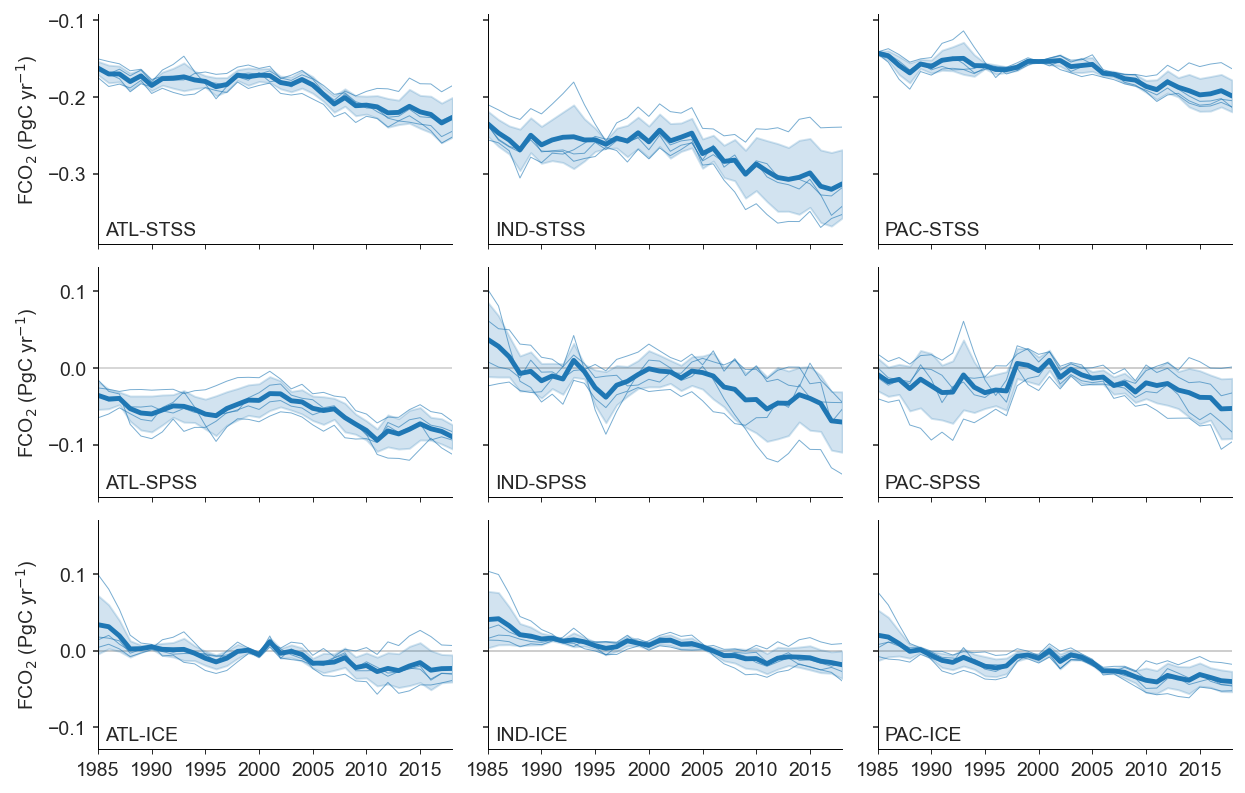

In [54]:
fig, ax = plt.subplots(3, 3, figsize=[9, 6], dpi=140, sharex='all', sharey='row')
# first transpose to draw plots columnwise
ax = ax.T.reshape(-1) 

for i, df in enumerate(flux_regions):    
    # resample the data to annual - could also smooth data instead
    df = df.resample(time='1AS').mean()
    
    # plot using premade function. Takes an ensemble and will plot the
    # ensemble members, mean of ensemble, stdev of ensemble (optional)
    plot.plot_ensemble(df, ax=ax[i], name='Data Products', color='C0')
    
    # add a label of the data on the bottom left of each ax
    name = mask.names.isel(idx=i).values
    ax[i].text(0.02, 0.02, name, va='bottom', ha='left', transform=ax[i].transAxes)

# conform plots to style. 
# draws y=0 line if in within plot range
# sets xticks to every 5 years
[plot.style_line_subplot(a, xlim=a.get_xlim(), y_range=0.3) for a in ax]
# only left subplot labels
[a.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)') for a in ax[:3]]

plt.show()

In [ ]:
rcParams['tick']